In [1]:
#importing necessary libraries
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import namedtuple
from moviepy.editor import VideoFileClip
from IPython.display import  HTML
%matplotlib inline

**Helper function for showing image lists**

In [2]:
def show_img_list(image_list, per_row, num_row, cmap=None, set_title=False):
    """Shows many number of images on per_row basis.
       If set_title is true then puts title original and output image
    """
    assert len(image_list)== per_row*num_row, \
    f"number of images in image_list must be equal to the per_row x num_row"
    
    
    fig,axes = plt.subplots(nrows=num_row, ncols=per_row)
    axes = axes.flatten()
    titles = ['Original Image', 'Output Image']

    fig.set_dpi(100)
    fig.set_tight_layout(True)
    fig.set_figheight(8)
    fig.set_figwidth(10)
    for idx,ax in enumerate(axes):
        ax.imshow(image_list[idx], cmap=cmap)
        # set title only work if there is two images for comparison purpose
        if set_title and len(image_list)==2:
            ax.set_title(titles[idx], fontsize=12)       

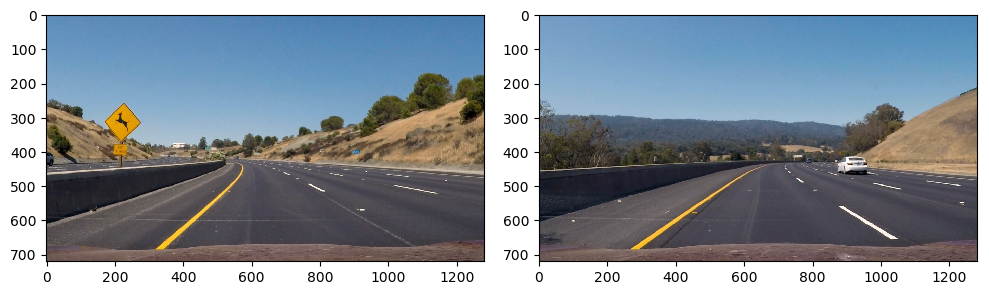

In [3]:
#read all the test images list
test_images = list(map(mpimg.imread, glob.glob('test_images/*.jpg')))
# show any two of them
show_img_list(test_images[2:4], 2, 1)

## Camera calibration and finding chess board corners

**First find the calibration matrix and then distortion co-efficient for a set of distorted chessboard images.**

In [4]:
#board-dimension
board_dim = (9, 6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
numx, numy = board_dim
objp = np.zeros((numx*numy,3), np.float32)
objp[:,:2] = np.mgrid[0:numx, 0:numy].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    #cv2.imread function read all images in 'BGR'  format not in 'RGB' format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, board_dim, None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, board_dim, corners, ret)
        #save image after drawing corners on 'camera_cal_output' folder
        mpimg.imsave('/'.join(['camera_cal_output', fname.split('/')[-1]]), img, format='jpg')

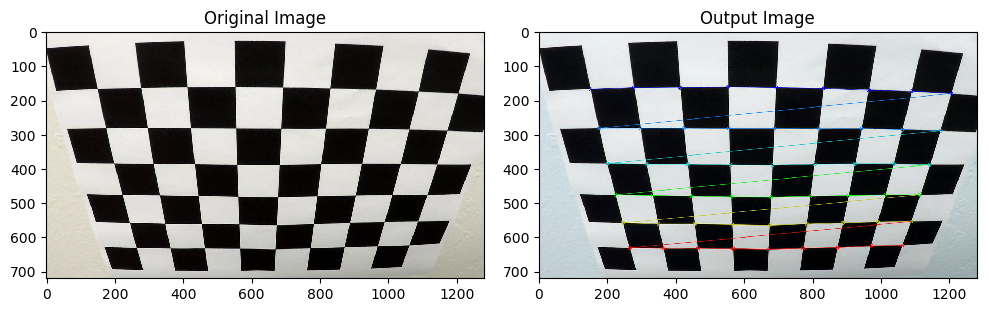

In [5]:
#plot original calibration image and the same after finding chess-board corner
orig_img = mpimg.imread('camera_cal/calibration2.jpg')
output_chessbrd = mpimg.imread('camera_cal_output/calibration2.jpg')
show_img_list([orig_img, output_chessbrd], 2, 1, set_title=True)

In [6]:
def undistort_image(img, object_pts, image_pts):
    """Function for undistorting a image by camera Calibration.
       Args:
       ----
       image_path: path to the image want to undistort
       objects_pts: object points which are 3d points in real world'sspace
       image_pts: 2d pts in image plane
       
       Return:
       The undistorted image
    """
    # Getting the shape or size for
    img_size = (img.shape[1], img.shape[0])
    #calibrate the camera and find the cameraMatrix and distortion coefficients
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                                         imgpoints,
                                                                         img_size, None, None)
    #Now undistort the image using cv2.undistort functio
    undistorted_img = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    
    return undistorted_img

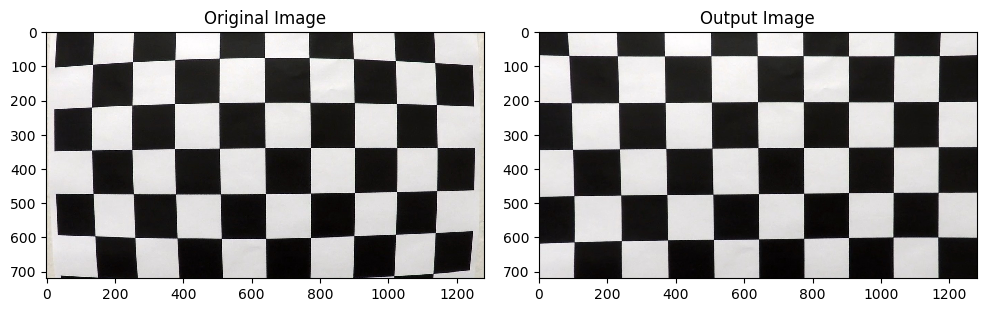

In [7]:
# show a calibration image before and after calibration
dist_img = mpimg.imread('camera_cal/calibration1.jpg')
undist_img = undistort_image(dist_img, objpoints, imgpoints)
show_img_list([dist_img, undist_img], 2, 1, set_title=True)

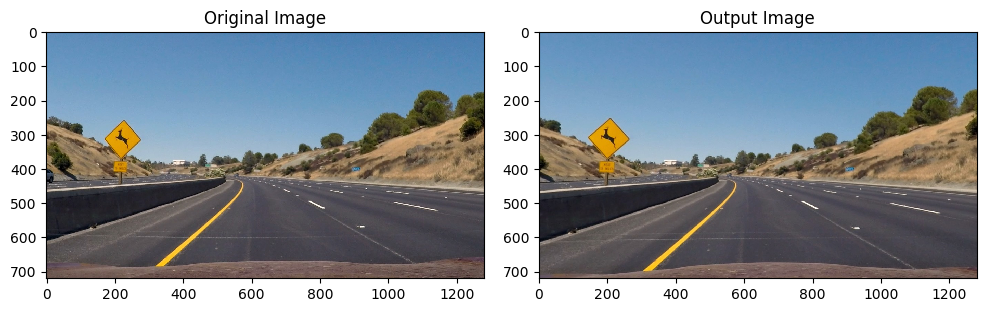

In [8]:
# show a test image before and after calibration
undist_test_img = undistort_image(test_images[2], objpoints, imgpoints)
show_img_list([test_images[2], undist_test_img], 2, 1, set_title=True)

In [9]:
class LaneMarker(object):
    """Lane marker class.
    Main task of this class is to provide all necessary methods
    to transform a image such that lane it is easy to detect lane line markings.
    
    a method transform_image is provided with all possible best parameters.
    
    But one can use other methods rather than transform_image to make their own
    pipelines with best parameters one have found.
    """
    
    def __init__(self, image):
        assert isinstance(image, (np.ndarray, list)), "Image must be in a numpy array or python list"
        self.image = image

    @property
    def gray_space(self):
        """function for converting the color space into grayscale"""
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

    @property
    def hls_space(self):
        """function for converting the color space into HLS space"""
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)

    @property
    def r_space(self):
        """function for converting the color space into R space"""
        return self.image[:,:,0]

    @property
    def g_space(self):
        """function for converting the color space into G space"""
        return self.image[:,:,1]

    @property
    def b_space(self):
        """function for converting the color space into B space"""
        return self.image[:,:,2]

    @property
    def h_space(self):
        """function for converting the color space into H space"""
        return self.hls_space[:,:,0]

    @property
    def l_space(self):
        """function for converting the color space into L space"""
        return self.hls_space[:,:,1]

    @property
    def s_space(self):
        """function for converting the color space into S space"""
        return self.hls_space[:,:,2]


    def _color_thresh(self, image_space, thresh_range):
        """function for returning binary thresolded image of a given image space
           arguments: image_space (one of 'gray', 'r', 'g', 'b', 'h', 'l', 's')
                      thresolding range (must be a tuple or list of len 2 with min
                      and max value respectively)
        """
        spaces = ['gray', 'r', 'g', 'b', 'h', 'l', 's']
        assert image_space in spaces, f"image space must be one of {', '.join(spaces)}"

        space = f"self.{image_space}_space"
        color_space = eval(space)
        
        space_binary = np.zeros_like(color_space)
        space_binary[(color_space >= thresh_range[0]) & (color_space <= thresh_range[1])] = 1
        
        return space_binary


    def _compute_sobel(self,image_space,kernel_size=3):
        '''Function for computing sobelx and sobely'''
        
        spaces = ['rgb', 'hls', 'gray', 'r', 'g', 'b', 'h', 'l', 's']
 
        assert image_space in spaces, f"image space must be one of {', '.join(spaces)}"

        image_space = f"self.{image_space}_space"
        
        #sobel operator for x gradient
        sobelx = cv2.Sobel(eval(image_space), cv2.CV_64F, 1, 0, ksize=kernel_size)
        #sobel operator for y grad
        sobely = cv2.Sobel(eval(image_space), cv2.CV_64F, 0, 1, ksize=kernel_size)

        return sobelx, sobely


    def abs_sobel_thresh(self, space, orient='x', thres=(0,255)):
        '''function that returns scaled binary thresold sobel based on colorspace,
           gradient direction orientation and thresold value.
        '''
        if orient == 'x':
            abs_sobel = np.absolute(self._compute_sobel(space)[0])

        elif orient == 'y':
            abs_sobel = np.absolute(self._compute_sobel(space)[1])
        #scale the absolute sobel in 
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        sbinary = np.zeros_like(scaled_sobel)
        sbinary[(scaled_sobel >= thres[0]) & (scaled_sobel <= thres[1])] = 1

        return sbinary


    def thresh_mag(self, space, mag_thres=(0,255)):
        """function that computes euclidean magnitude of sobel components
           on a particular color space.
           Returns a thresolded binary image of computed magnitude
        """

        sobelx, sobely = self._compute_sobel(space)
        #computing the magnitude for x and y components
        grad_mag = np.hypot(sobelx, sobely)
        # scaling the image
        scale_factor = np.max(grad_mag)/255
        grad_mag = (grad_mag/scale_factor).astype(np.uint8)
        
        #computing thresolded binary
        binary_output = np.zeros_like(grad_mag)
        binary_output[(grad_mag >= mag_thres[0]) & (grad_mag <= mag_thres[1])] = 1

        # Return the binary image
        return binary_output


    def thresh_dir(self, space, thres=(0, np.pi/2)):
        """function that computes slope of sobel components
           on a particular color space.
           Returns a thresolded binary image of computed slope
        """
        sobelx, sobely = self._compute_sobel(space)
        
        # compute the slope of absolute components(tan<-1>(y/x))
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thres[0]) & (absgraddir <= thres[1])] = 1

        # Return the binary image
        return binary_output


    def transform_image(self,
                 grad_space='gray',
                 color_space='s',
                 grad='x',
                 grad_thresh=(20,100),
                 color_thresh=(170,255)):
        """
        Arguments:
           grad_space: color space in which gradient will be computed.(default: grayscale)
           color_space: color space in which color thresolding will be done.(defalult: s [saturation])
           grad : either 'x' or 'y' (the direction where sobel value will be calculated)
           grad_thresh: default is (20, 100)
           color_thresh: default is (170, 255)
           
        return two binary images color_binary and combined_binary
        """

        grad_binary = self.abs_sobel_thresh(space=grad_space, orient=grad, thres=grad_thresh)

        space_binary = self._color_thresh(image_space=color_space, thresh_range=color_thresh)

        color_binary = np.dstack(( np.zeros_like(grad_binary), grad_binary, space_binary))

        combined_binary = np.zeros_like(grad_binary)

        combined_binary[(space_binary == 1) | (grad_binary == 1)] = 1

        return color_binary, combined_binary

In [10]:
# source and destination points for perspective transform
# It is chosen manually that is why it can't be used in other video frames
# Creating a named tuple object called Points with src and dst attribute
Points = namedtuple('Points', ['src', 'dst'])
SRC = [[700, 460], [1140, 720], [200, 720], [580, 460]]
DST = [[950, 0], [950, 720], [300, 720], [300, 0]]
pts = Points(SRC, DST)

In [11]:
# Define Perspective transform function
def wrap(img, src, dst):
    """function that wraps an image with src and dst given
       returns the wraped image with transform matrix and its inverse.
    """
    # undistort images
    img = undistort_image(img, objpoints, imgpoints)
    
    # Define calibration box in source (original) and destination (desired or wrapped) coordinates
    img_size = (img.shape[1], img.shape[0])

    # Four source coordinates
    src = np.float32(src)

    # Four desired coordinates
    dst = np.float32(dst)

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective Minv
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create the wrapped image = uses linear interpolation
    wraped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return wraped, M, Minv

In [12]:
# Now checking our transform_image method and wrap function how working on test images
transformed_imgs = list(map(lambda x: LaneMarker(x).transform_image()[1], test_images))
wraped_imgs = list(map(lambda x:wrap(x, pts.src, pts.dst)[0], transformed_imgs))

In [13]:
# saving all the images
image_names = os.listdir('test_images')
TRANSFORMED_PATH = 'test_images_transformed'
WRAPED_PATH = 'test_images_wraped'

if not os.path.exists(TRANSFORMED_PATH):
    os.mkdir(TRANSFORMED_PATH)
    
if not os.path.exists(WRAPED_PATH):
    os.mkdir(WRAPED_PATH)
    
for timg, wimg, fname in zip(transformed_imgs, wraped_imgs, image_names):
    mpimg.imsave(os.path.join(TRANSFORMED_PATH, fname), timg, format='jpg', cmap='gray')
    mpimg.imsave(os.path.join(WRAPED_PATH, fname), wimg, format='jpg', cmap='gray')

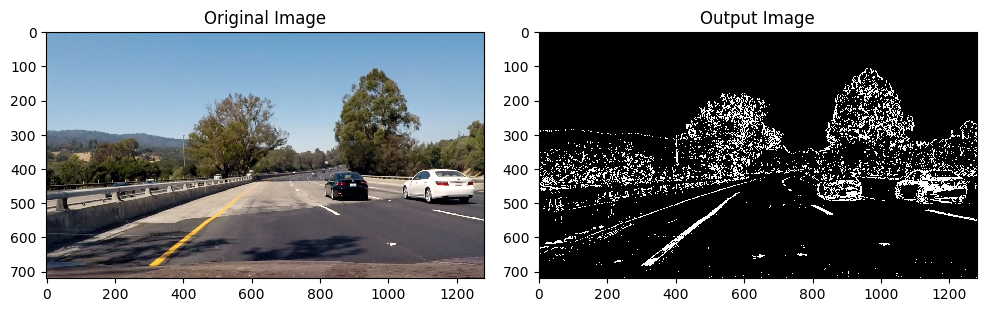

In [14]:
# showing any image before and after transformation
show_img_list([test_images[5], transformed_imgs[5]], 2, 1, set_title=True, cmap='gray')

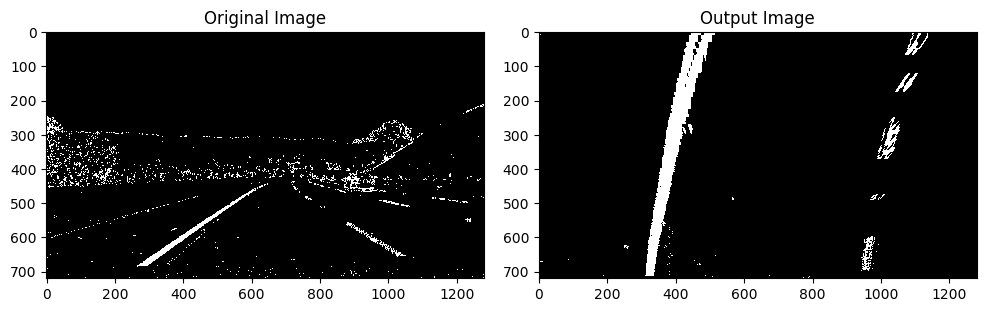

In [15]:
# showing any image before and after wraping
show_img_list([transformed_imgs[3], wraped_imgs[3]], 2, 1, set_title=True, cmap='gray')

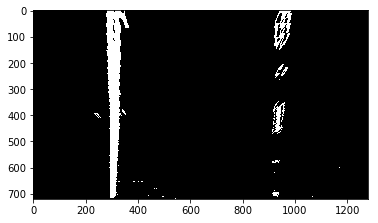

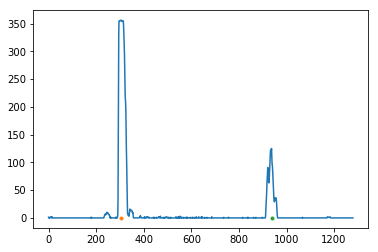

In [16]:
# computing the histogram of pixels of a
# wraped binary image and plot it

wraped = wraped_imgs[0]
out_wrap = np.dstack((wraped, wraped, wraped))*255
out_wrap_copy = np.copy(out_wrap)

histogram = np.sum(wraped[wraped.shape[0]//2:,:], axis=0)

mid_point = np.int(histogram.shape[0]/2)

# choosing the leftx_base 200px right and rightx_base from 900px(1280/2+200~900)
# because the laneline started in the image 200px right 
# argmax function will give the index points where the value of histogram highest
# as this will detect the indices containing the white lane lines in binary
# wraped image
leftx_base = np.argmax(histogram[200:mid_point]) + 200
rightx_base = np.argmax(histogram[900:])+ 900

#plotting the image
plt.imshow(wraped,cmap='gray')
plt.show()
#plotting the histogram
plt.plot(histogram)
plt.plot(leftx_base,0,'.')
plt.plot(rightx_base,0,'.')
plt.show()

In [17]:
# divide the whole window into 9 parts of each 80 pixl
n_windows = 9

window_height = np.int(wraped.shape[0]/n_windows)

nonzero_y,nonzero_x = wraped.nonzero()

leftx_current = leftx_base
rightx_current = rightx_base

margin= 100
minpix = 50
# list for appending lane line indices
left_lane_idc = []
right_lane_idc = []

In [18]:
# now iterate through all windows and identify the good pixels
# and append it to left_lane_idc and right_lane_idc
for window in range(n_windows):
    # Identify Window boundaries with x,y(for left and right)
    win_y_low = wraped.shape[0] - (window+1) * window_height
    win_y_high = wraped.shape[0] - window * window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    #Draw the windows on visualization image
    cv2.rectangle(out_wrap,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),6)
    cv2.rectangle(out_wrap,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),6)
    
    # Identify the nonzero pixels in x and y with in the window
    good_left_indcs = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & \
                       (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]   
    good_right_indcs = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & \
                        (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]  
    
    # Append this indices to lists
    left_lane_idc.append(good_left_indcs)
    right_lane_idc.append(good_right_indcs)
    
    # If good_indcs > minpix,recenter next window on their mean position
    if len(good_left_indcs) > minpix:
        leftx_current = np.int(np.mean(nonzero_x[good_left_indcs]))
        
    if len(good_right_indcs) > minpix:
        rightx_current = np.int(np.mean(nonzero_x[good_right_indcs]))
        

# Concatenate the array of windows
left_lane_idc = np.concatenate(left_lane_idc)
right_lane_idc = np.concatenate(right_lane_idc)

# Extract left and right line pixel positions
leftx = nonzero_x[left_lane_idc]
lefty = nonzero_y[left_lane_idc]
rightx = nonzero_x[right_lane_idc]
righty = nonzero_y[right_lane_idc]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

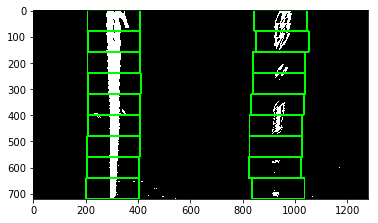

In [19]:
#Now rectangles have been drawn on binary images
plt.imshow(out_wrap, cmap='gray')
plt.show()

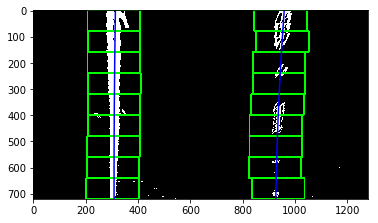

In [20]:
# Visualization
ploty = np.linspace(0, wraped.shape[0]-1, wraped.shape[0])

left_fitx = left_fit[0]*ploty**2  + left_fit[1]*ploty  + left_fit[2]
right_fitx = right_fit[0]*ploty**2  + right_fit[1]*ploty  + right_fit[2]

# Now draw the second order polynomial to the image out_wrap
plt.imshow(out_wrap, cmap='gray')
plt.plot(left_fitx, ploty, color='blue')
plt.plot(right_fitx, ploty, color='blue')
plt.show()

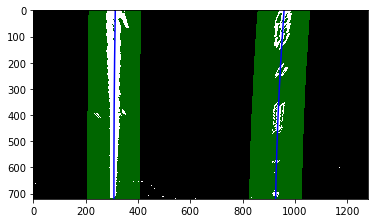

In [21]:
#creating a blank window image
window_img = np.zeros_like(out_wrap)

out_wrap[nonzero_y[left_lane_idc], nonzero_x[left_lane_idc]] = [255,0,0]
out_wrap[nonzero_y[right_lane_idc], nonzero_x[right_lane_idc]] = [0,0,255]

# deriving left lane and right lane points to draw polygons on it
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
left_line_pts = np.hstack((left_line_window1,left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
right_line_pts = np.hstack((right_line_window1,right_line_window2))

# Draw the lane onto wraped blank image
cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
result = cv2.addWeighted(out_wrap_copy, 1, window_img, 0.4, 0)

# showing the result 
plt.imshow(result)
plt.plot(left_fitx,ploty,color='blue')
plt.plot(right_fitx,ploty,color='blue')
plt.xlim(0,1280)
plt.ylim(720,0)
print()

In [22]:
def put_txt(frame,
            color=(255, 255, 255),
            line=cv2.LINE_AA,
            font=cv2.FONT_HERSHEY_COMPLEX_SMALL,
            **kwargs):
    """function for writing text data on image frame.
       Valid keyword args:
       curve_rad: radius of curvature
       pos: Position of car with respect to centre of lane lines. a tuple
            valid example: (.3,'left')
       min_curve_rad: Minimum radius of curvature
    """
    curve_rad = kwargs['curve_rad']
    position, dirc = kwargs['pos']
    min_curve_rad = kwargs['min_curve_rad']
    
    cv2.putText(frame,f"Radius of curvature is {curve_rad:.2f} m.", (20, 20), font, 1, color, 1, line)
    cv2.putText(frame,f"vehicle is {position:.2f}m. {dirc} of center", (20, 50), font, 1, color, 1, line)
    cv2.putText(frame,f"min. radius of curvature is {min_curve_rad:.2f}", (20, 80), font, 1, color, 1, line)
    
    return frame

In [23]:
# Now stacking it all together 
COUNTER = 1
lrfit = []

def pipeline_func(img):
    '''Image pipeline function for for detecting lane lines'''
    
    # creating a named tuple object for source and destination
    # SRC and DST declared as global constant 
    pts = Points(SRC, DST)
    
    img = undistort_image(img, objpoints, imgpoints)# undistorting the image
    lane_obj = LaneMarker(img) #creating a lanemarker object
    
    #getting the thresolded colored binary and combined binary image
    colored_bin, comb_bin_img = lane_obj.transform_image()
    # getting the wraped image perspective traform matrix and it's inverse
    wraped, M, Minv = wrap(comb_bin_img, pts.src, pts.dst)
    #depth wise stacking the wraped images 
    out_wrap = np.dstack((wraped, wraped, wraped)) * 255

    # computing the histogram
    histogram = np.sum(wraped[wraped.shape[0]//2:,:], axis=0)
    # getting the middle point for detecting histogram peaks 
    mid_point = np.int(histogram.shape[0]/2)
    
    # choosing the leftx_base 200px right and rightx_base from 900px(1280/2+200~900)
    # because the laneline started in the image 200px right 
    # argmax function will give the index points where the value of histogram highest
    # as this will detect the indices containing the white lane lines in binary
    # wraped image
    leftx_base = np.argmax(histogram[200:mid_point]) + 200
    rightx_base = np.argmax(histogram[900:])+ 900
    
    # image height is 720px so taking 9 windows of 80px each
    n_windows = 9
    window_height = np.int(wraped.shape[0]/n_windows)
    
    # getting the nonzerox and nonzeroy
    nonzero_y,nonzero_x = wraped.nonzero()

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin= 100
    minpix = 50

    left_lane_idc = []
    right_lane_idc = []

    # defining counter as global variable as we will change it's value during iteration
    # python will interpret this as local variable and will raise unbound local error.
    # counter counts first iteration to find the lane line indices and after that search
    # willbe conducted within a specified margin
    global COUNTER
    
    if COUNTER > 0:
        # iterate through all windows
        for window in range(n_windows):
            # Identify Window boundaries with x,y(for left and right)
            win_y_low = wraped.shape[0] - (window+1) * window_height
            win_y_high = wraped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y with in the window
            good_left_indcs = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & \
                               (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
            good_right_indcs = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & \
                                (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]

            # Append this indices to lists
            left_lane_idc.append(good_left_indcs)
            right_lane_idc.append(good_right_indcs)

            # If good_indcs > minpix,recenter next window on their mean position
            if len(good_left_indcs) > minpix:
                leftx_current = np.int(np.mean(nonzero_x[good_left_indcs]))

            if len(good_right_indcs) > minpix:
                rightx_current = np.int(np.mean(nonzero_x[good_right_indcs]))

        # Concatenate the array of windows
        left_lane_idc = np.concatenate(left_lane_idc)
        right_lane_idc = np.concatenate(right_lane_idc)
        COUNTER -= 1
    else:
        left_fit, right_fit = lrfit[-1]
        la, lb, lc = left_fit
        ra, rb, rc = right_fit
        left_lane_idc = ((nonzero_x > (la*(nonzero_y**2) + lb*nonzero_y + lc - margin)) & \
                         (nonzero_x < (la*(nonzero_y**2) + lb*nonzero_y + lc + margin)))
        right_lane_idc = ((nonzero_x > (ra*(nonzero_y**2) + rb*nonzero_y + rc - margin)) & \
                          (nonzero_x < (ra*(nonzero_y**2) + rb*nonzero_y + rc + margin)))



    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_idc]
    lefty = nonzero_y[left_lane_idc]
    rightx = nonzero_x[right_lane_idc]
    righty = nonzero_y[right_lane_idc]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    lrfit.append((left_fit, right_fit))

    # Visualization
    ploty = np.linspace(0, wraped.shape[0]-1, wraped.shape[0])

    left_fitx = left_fit[0]*ploty**2  + left_fit[1]*ploty  + left_fit[2]
    right_fitx = right_fit[0]*ploty**2  + right_fit[1]*ploty  + right_fit[2]

    out_wrap[nonzero_y[left_lane_idc], nonzero_x[left_lane_idc]] = [255, 0, 0]
    out_wrap[nonzero_y[right_lane_idc], nonzero_x[right_lane_idc]] = [0, 0, 255]

    wrap_zero = np.zeros_like(wraped).astype(np.uint8)
    color_wrap = np.dstack((wrap_zero, wrap_zero, wrap_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # drawing polynomials
    cv2.fillPoly(color_wrap, np.int_([pts]), (0, 255, 0))
    
    # getting the final unwraped image and combining with the original image
    new_wrap = cv2.warpPerspective(color_wrap, Minv, (1280, 720))
    res = cv2.addWeighted(img, 1, new_wrap, 0.4, 0)

    y_eval = np.max(ploty)
    # Conversion to meter
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    # getting the y values in meters for calculating vehicle position
    yleft_pos = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    yright_pos = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)\
                     / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)\
                     / np.absolute(2*right_fit_cr[0])
    
    # curvature from the centre of the lane lines
    curvature = (left_curverad + right_curverad)/2
    #minimum curvature
    min_curvature = min([left_curverad, right_curverad])
    
    #position of the vehicle with respect to centre of laneline
    vehicle_pos = (1.5*yleft_pos - yright_pos)/2
    pos_val = np.abs(vehicle_pos)
    pos_dir = 'left' if vehicle_pos<0 else 'right'
    pos = (pos_val, pos_dir)
    
    #writing data to frame
    put_txt(res, curve_rad=curvature, pos=pos, min_curve_rad=min_curvature)
    
    return res

In [24]:
#applying the function on all test images
#and save it to a test_output directory
test_output = list(map(pipeline_func, test_images))
if not os.path.exists('test_output'):
    os.mkdir('test_output')
    
for fname, img in zip(image_names, test_output):
    mpimg.imsave(os.path.join('test_output', fname), img, format='jpg')

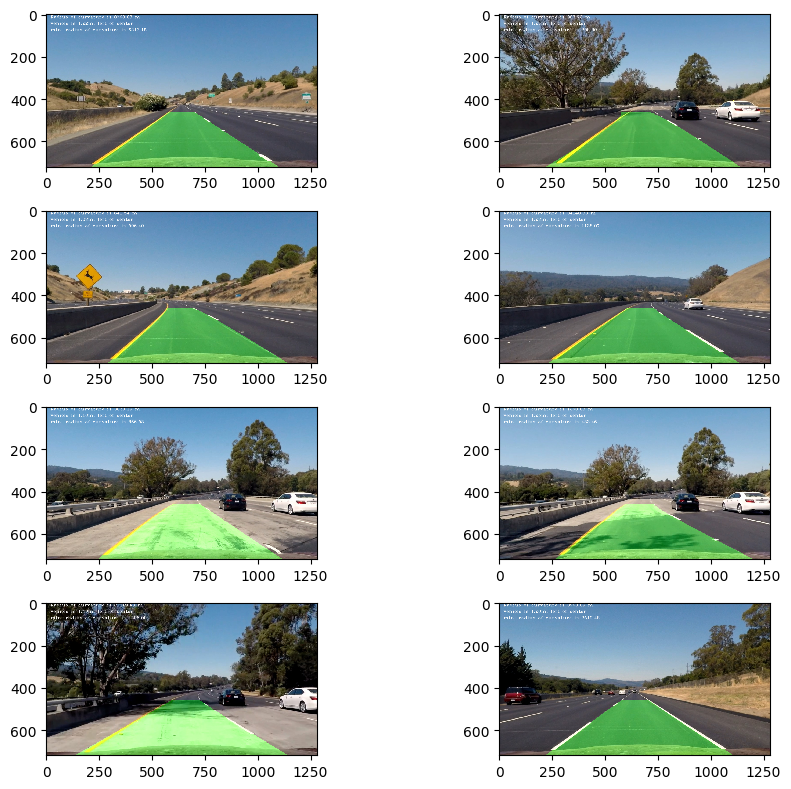

In [25]:
show_img_list(test_output, 2, 4)

In [26]:
# now apply the image func in a video frame
# andsave it to a file called output.mp4
clip = VideoFileClip('project_video.mp4')
fl = clip.fl_image(pipeline_func)
fl.write_videofile('output.mp4',audio=True)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing audio in outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2525.85it/s]

[MoviePy] Done.
[MoviePy] Writing video output.mp4



100%|█████████▉| 1260/1261 [26:07<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))